In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import createlookup as cl

In [2]:
raw_df = pd.read_csv('../../datasets/Iowa_Liquor_Sales.csv')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df = raw_df[['Date', 'Store Name', 'City', 'County', 'Item Description', 'Bottles Sold',
       'Sale (Dollars)', 'Volume Sold (Liters)', 'Volume Sold (Gallons)']]

In [4]:
df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y")
df['Year'] = df['Date'].dt.year

<ipython-input-4-8fcad510baa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y")
<ipython-input-4-8fcad510baa5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year


In [5]:
# checking NAs
df[df.columns].isna().sum()

Date                          4
Store Name                    4
City                      27994
County                   104798
Item Description              5
Bottles Sold                  5
Sale (Dollars)               15
Volume Sold (Liters)          5
Volume Sold (Gallons)         5
Year                          4
dtype: int64

In [6]:
# dropping the columns with no year/storename
df = df[df['Date'].notnull() & df['Store Name'].notnull() & df['Item Description'].notnull() & df['Bottles Sold'].notnull()]

In [7]:
liqour_counts = pd.read_csv('liqour_counts.csv')

In [8]:
df = pd.concat([df, liqour_counts], axis=1)

In [9]:
# getting counties with null values
null_counties = df[df['County'].isnull()]

In [10]:
# get the substring for city after store name
def substring_after(s, delim):
    return s['Store Name'].partition(delim)[2]

null_counties['City'] = null_counties.apply(lambda row: substring_after(row, "/ "), axis=1)
# make sure the city exists
null_counties = null_counties[null_counties['City'] != ""]

<ipython-input-10-0ee1379c6d5c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_counties['City'] = null_counties.apply(lambda row: substring_after(row, "/ "), axis=1)


In [11]:
# get cities with no existing county name
no_county_cities = null_counties['City'].unique()

In [12]:
no_county_cities = [x.title().strip() for x in no_county_cities]

In [13]:
name_fixes = {'4Th St Waukee': 'Waukee', 'Humbolt':'Humboldt', 'Missouri Valey':'Missouri Valley', 
                        'Humest':'Humeston', 'Lafayette / Waterloo': 'Waterloo', 'Ft Dodg':'Fort Dodge', 'West Dsm':'West Des Moines', 
                         'Urband': 'Urbandale', 'Marsha':'Marshalltown', 'State Ankeny':'Ankeny', 'Lemars': 'Le Mars', 'Seymou': 'Seymour', 
                        'Dewitt': 'DeWitt', 'Otumwa':'Ottumwa', 'Coralvill':'Coralville', 'Mason Cit':'Mason City', 'Lafayet / Waterloo':'Waterloo',
              'Runn':'Runnells', 'Audubo':'Audubon', 'Norwal': 'Norwalk', 'Sac Ci': 'Sac City', 'Forest': 'Forest City', 'Missouri V': 'Missouri Valley',
              'Stanto':'Stanton'
             }

In [14]:
city_county_lookup = cl.create_lookup(no_county_cities, name_fixes)

In [15]:
# remove any extra cities that can't be identified
lookup = city_county_lookup[city_county_lookup['County'].notnull()]

In [16]:
null_counties.drop('County', axis=1, inplace= True)

In [17]:
lookup['County'] = lookup['County'].astype(str).str.upper()
lookup['City'] = lookup['City'].astype(str).str.upper()
null_counties['City'] = null_counties['City'].astype(str).str.upper()
null_counties = pd.merge(null_counties, lookup,  how='left', left_on=['City'], right_on = ['City'])

<ipython-input-17-4de609f7ec95>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lookup['County'] = lookup['County'].astype(str).str.upper()
<ipython-input-17-4de609f7ec95>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lookup['City'] = lookup['City'].astype(str).str.upper()


In [18]:
#get all the observations with null counties that are now identified
found_counties = null_counties[null_counties['County'].notnull()]

In [19]:
# get all rows of orig df with known counties
known_counties = df[df['County'].notnull()]

In [20]:
# concat obs with known and found counties
df_clean = pd.concat([found_counties, known_counties])

In [21]:
len(df)

21499067

In [22]:
len(df_clean)

21447245

In [23]:
df_clean['County'] = df_clean['County'].str.upper()

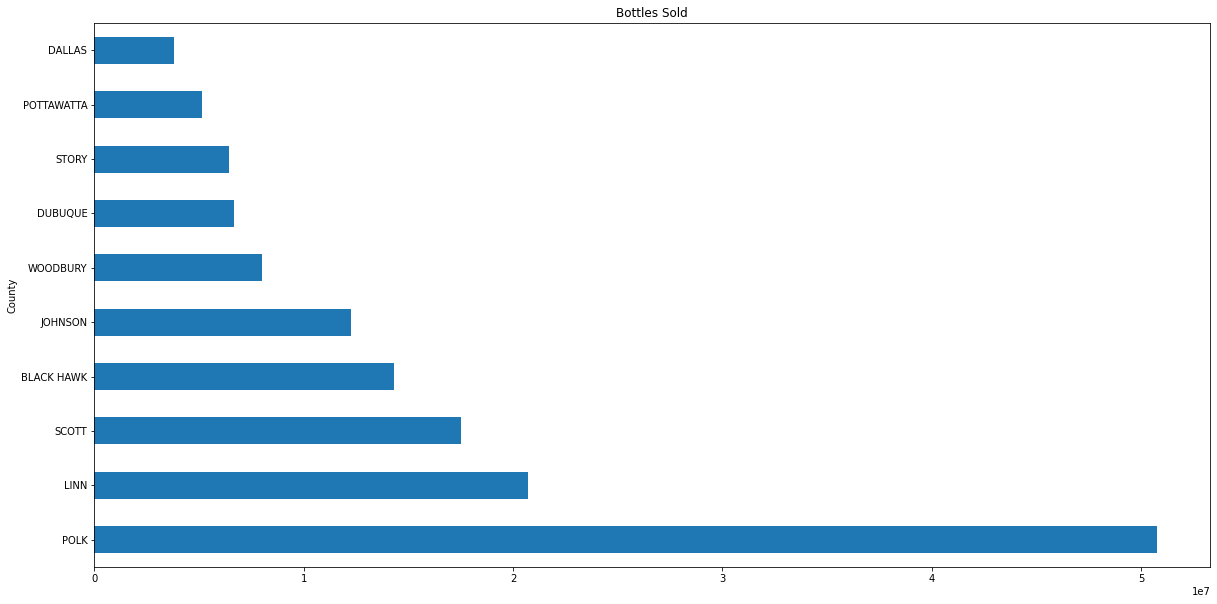

In [24]:
df_clean.groupby('County')['Bottles Sold'].sum().sort_values(ascending=False).head(10).plot(kind='barh', figsize=(20,10))
plt.title('Bottles Sold')
plt.show()

In [25]:
df_clean.head()

,Date,Store Name,City,Item Description,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Year,Gin,Rum,Tequila,Vodka,Whiskey,OTHER,County
0,2018-01-23,Casey's General Store #1365 / Paullina,PAULLINA,Black Velvet,12.0,94.20,9.0,2.38,2018.0,0.0,0.0,0.0,0.0,0.0,12.0,O'BRIEN
1,2018-01-24,Mart Stop #1 / Davenport,DAVENPORT,Grey Goose Vodka,12.0,162.00,4.5,1.19,2018.0,0.0,0.0,0.0,12.0,0.0,0.0,SCOTT
2,2018-01-29,Foodland Super Markets / Woodbine,WOODBINE,Seagrams 7 Crown Bl Whiskey,2.0,21.00,1.5,0.40,2018.0,0.0,0.0,0.0,0.0,2.0,0.0,HARRISON
3,2018-02-01,Sam's Club 6344 / Windsor Heights,WINDSOR HEIGHTS,Absolut Mandrin,12.0,269.88,12.0,3.17,2018.0,0.0,0.0,0.0,12.0,0.0,0.0,POLK
4,2018-01-24,Mart Stop #1 / Davenport,DAVENPORT,Captain Morgan Spiced Rum Mini,12.0,86.40,6.0,1.59,2018.0,0.0,12.0,0.0,0.0,0.0,0.0,SCOTT


## Aggregating Data

In [26]:
df_agg = df_clean.groupby(['Date', 'County'],as_index=False)[['Bottles Sold', 'Sale (Dollars)','Volume Sold (Liters)', 'Volume Sold (Gallons)', 'Gin', 'Rum', 'Tequila', 'Vodka', 'Whiskey', 'OTHER' ]].sum()

In [27]:
df_agg['Year'] = df_agg['Date'].dt.year

In [32]:
county_fix = {'CERRO GORD': 'CERRO GORDO', 'POTTAWATTA':'POTTAWATTAMIE', 'OBRIEN':"O'BRIEN", 'BUENA VIST':'BUENA VISTA'}

In [34]:
# fixing county info
df_agg['County'] = df_agg['County'].replace(county_fix)

## Merging in Estimates

In [80]:
ests = pd.read_csv("EstimatesFinal.csv")
ests['County'] = ests['County'].str.upper()

new_df = pd.merge(df_agg, ests,  how='left', left_on=['County','Year'], right_on = ['County','Year'])
new_df

,Date,County,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Gin,Rum,Tequila,Vodka,...,Asian ME,Pacific Estimate,Pacific ME,Other Estimate,Other ME,Two+ Estimate,Two+ ME,HighIncome,LowIncome,MidIncome
0,2012-01-03,ADAIR,339.0,4270.73,319.12,84.26,2.0,22.0,0.0,39.0,...,19.0,0.0,13.0,13.0,14.0,48.0,23.0,215.0,539.0,1296.0
1,2012-01-03,ADAMS,113.0,1491.20,112.94,29.77,3.0,6.0,9.0,18.0,...,12.0,0.0,9.0,0.0,9.0,64.0,21.0,120.0,261.0,790.0
2,2012-01-03,AUDUBON,269.0,2909.50,235.63,62.30,0.0,44.0,4.0,76.0,...,17.0,0.0,13.0,0.0,13.0,60.0,35.0,216.0,557.0,941.0
3,2012-01-03,BENTON,108.0,1282.32,94.50,24.97,0.0,6.0,0.0,30.0,...,34.0,0.0,17.0,65.0,68.0,268.0,89.0,1247.0,1440.0,4512.0
4,2012-01-03,BLACK HAWK,128.0,1430.20,110.10,29.10,0.0,18.0,6.0,36.0,...,218.0,23.0,28.0,1997.0,428.0,2861.0,426.0,3961.0,8829.0,18194.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85570,2022-08-31,WARREN,342.0,4805.82,287.70,75.92,6.0,0.0,6.0,54.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85571,2022-08-31,WASHINGTON,2837.0,32482.06,2502.75,660.28,102.0,99.0,42.0,183.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85572,2022-08-31,WINNEBAGO,1937.0,24790.31,1666.22,439.40,20.0,0.0,12.0,447.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85573,2022-08-31,WOODBURY,231.0,2355.17,119.50,31.41,0.0,4.0,0.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
new_df[(new_df['Year'] <= 2020) & new_df["MidIncome"].isnull()]['County'].unique()

array(['EL PASO'], dtype=object)

In [82]:
# get years before 2021 (no population estimates for them)
new_df_2020 = new_df[(new_df['Year'] <= 2020)]

In [83]:
new_df_2020['County'].value_counts()

POLK          2161
LINN          1903
JOHNSON       1763
BLACK HAWK    1721
STORY         1586
              ... 
DAVIS          404
TAYLOR         396
ADAMS          364
FREMONT        139
EL PASO          1
Name: County, Length: 100, dtype: int64

In [84]:
# filter out EL PASO since that's now a county
new_df_2020 = new_df_2020[new_df_2020['County'] != 'EL PASO']

In [85]:
new_df_2020['County'].value_counts()

POLK          2161
LINN          1903
JOHNSON       1763
BLACK HAWK    1721
STORY         1586
              ... 
KEOKUK         407
DAVIS          404
TAYLOR         396
ADAMS          364
FREMONT        139
Name: County, Length: 99, dtype: int64

In [86]:
new_df_2020.columns

Index(['Date', 'County', 'Bottles Sold', 'Sale (Dollars)',
       'Volume Sold (Liters)', 'Volume Sold (Gallons)', 'Gin', 'Rum',
       'Tequila', 'Vodka', 'Whiskey', 'OTHER', 'Year', 'Poverty ',
       'Middle-Old', 'Middle-Young', 'Old', 'Young', 'Population',
       'White Estimate', 'White ME', 'Black Estimate', 'Black ME',
       'Native American Estimate', 'Native American ME', 'Asian Estimate',
       'Asian ME', 'Pacific Estimate', 'Pacific ME', 'Other Estimate',
       'Other ME', 'Two+ Estimate', 'Two+ ME', 'HighIncome', 'LowIncome',
       'MidIncome'],
      dtype='object')

In [87]:
new_df_2020['Bottles Sold PC'] = new_df_2020['Bottles Sold']/new_df_2020['Population']
new_df_2020['Sales Volume PC'] = new_df_2020['Sale (Dollars)']/new_df_2020['Population']
new_df_2020['Volume Sold PC'] = new_df_2020['Volume Sold (Liters)']/new_df_2020['Population']
new_df_2020['Vodka Sold PC'] = new_df_2020['Vodka']/new_df_2020['Population']
new_df_2020['Gin Sold PC'] = new_df_2020['Gin']/new_df_2020['Population']
new_df_2020['Rum Sold PC'] = new_df_2020['Rum']/new_df_2020['Population']
new_df_2020['Whiskey Sold PC'] = new_df_2020['Whiskey']/new_df_2020['Population']
new_df_2020['Tequila Sold PC'] = new_df_2020['Tequila']/new_df_2020['Population']
new_df_2020['Other Alc Sold PC'] = new_df_2020['OTHER']/new_df_2020['Population']

In [88]:
new_df = new_df_2020.drop(columns=['White ME', 'Black ME', 'Native American ME', 'Asian ME', 'Pacific ME', 'Other ME', 'Two+ ME',
                         'Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)', 'Volume Sold (Gallons)', 'County', 'Vodka',
                         'Gin', 'Rum', 'Whiskey', 'Tequila', 'OTHER'])

In [89]:
new_df.columns

Index(['Date', 'Year', 'Poverty ', 'Middle-Old', 'Middle-Young', 'Old',
       'Young', 'Population', 'White Estimate', 'Black Estimate',
       'Native American Estimate', 'Asian Estimate', 'Pacific Estimate',
       'Other Estimate', 'Two+ Estimate', 'HighIncome', 'LowIncome',
       'MidIncome', 'Bottles Sold PC', 'Sales Volume PC', 'Volume Sold PC',
       'Vodka Sold PC', 'Gin Sold PC', 'Rum Sold PC', 'Whiskey Sold PC',
       'Tequila Sold PC', 'Other Alc Sold PC'],
      dtype='object')

In [90]:
new_df['DOW'] = new_df['Date'].dt.day_name()
new_df['dow_temp'] = new_df['Date'].dt.dayofweek

In [91]:
def is_weekend(day):
    if day >=5:
        return 1
    else:
        return 0

new_df['is_weekend'] = new_df['dow_temp'].apply(is_weekend)
new_df = new_df.drop(columns=['dow_temp'])

In [94]:
new_df['Age Estimate Total'] = new_df[['White Estimate','Black Estimate','Native American Estimate','Asian Estimate','Pacific Estimate','Other Estimate','Two+ Estimate']].sum(axis=1)
races = ['White', 'Black', 'Native American', 'Asian', 'Pacific', 'Two+', 'Other']
for r in races:
    new_df['{} Prop'.format(r)] = new_df['{} Estimate'.format(r) ]/new_df['Age Estimate Total']

In [98]:
new_df['Household Income Total'] = new_df[['HighIncome', 'LowIncome', 'MidIncome']].sum(axis=1)
income_level = ['High', 'Low', 'Mid']
for i in income_level:
    new_df['{}Income Prop'.format(i)] = new_df['{}Income'.format(i) ]/new_df['Household Income Total']

In [99]:
new_df['Age Total'] = new_df[['Middle-Old', 'Middle-Young', 'Old',
       'Young']].sum(axis=1)
age_range = ['Middle-Old', 'Middle-Young', 'Old',
       'Young']
for a in age_range:
    new_df['{} Prop'.format(a)] = new_df['{}'.format(a) ]/new_df['Age Total']

In [100]:
new_df_prop = new_df.drop(columns=['Middle-Old', 'Middle-Young', 'Old',
       'Young', 'HighIncome', 'LowIncome', 'MidIncome', 'White Estimate','Black Estimate',
        'Native American Estimate','Asian Estimate','Pacific Estimate','Other Estimate','Two+ Estimate',
        'Age Total', 'Household Income Total', 'Age Estimate Total'])

In [102]:
new_df_prop.columns

Index(['Date', 'Year', 'Poverty ', 'Population', 'Bottles Sold PC',
       'Sales Volume PC', 'Volume Sold PC', 'Vodka Sold PC', 'Gin Sold PC',
       'Rum Sold PC', 'Whiskey Sold PC', 'Tequila Sold PC',
       'Other Alc Sold PC', 'DOW', 'is_weekend', 'White Prop', 'Black Prop',
       'Native American Prop', 'Asian Prop', 'Pacific Prop', 'Two+ Prop',
       'Other Prop', 'HighIncome Prop', 'LowIncome Prop', 'MidIncome Prop',
       'Middle-Old Prop', 'Middle-Young Prop', 'Old Prop', 'Young Prop'],
      dtype='object')

In [103]:
new_df_prop.to_csv('harlech_data_proportions.csv')